As with everyone else Titanic is my first entry in Kaggle.I am a newbie to Machine Learning and believe in Learning by doing(or in ML terms ..Tuning my personal parameters after every run ; ) ).My Idea of solving a problem revolves around the WHAT ,HOW and WHY and I have tried to explain my thought process at every step of decision making(some are missing and will update the documentation further)

This code is subject to improvement as I will be adding more algorithms for the Ensemble modelling and tuning the hyper parameters further.

**Importing Modules**

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , VotingClassifier , AdaBoostClassifier , ExtraTreesClassifier , GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score , StratifiedKFold , GridSearchCV , learning_curve
from xgboost.sklearn import XGBClassifier

**Aquiring Data**

Pandas read_csv method is used to input the training and test data in dataframes.

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
train_len=len(train_df)
train_len


891

In [3]:
train_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
test_df.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [5]:
dataset=pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)

**Variable Identification**

WHAT ? 

Identify the different Variables/Feature present in the data on the lines of :

a.Type (Predictor , Target)

b.Datatype (Char , Numerical(Discrete , Continuous ,Timeseries based)) 

c.Variable Category (Categorical((Nominal,Ordinal,Ratio or Interval-based)) , Continuous)

HOW ? 

train_df.describe() # Numeric Variables 

train_df.describe(include=['O']) # Character/Object Variables Some numeric type features can also be categorical.Idea can be drawn from looking at the columns names along with unique values 

print("Survived");

print(len(train_df.Survived.unique())) 

print("Pclass");

print(len(train_df.Pclass.unique()))

WHY ? 

Knowing columns type will help us in analysing the data.It helps us in deciding what type of Visualization to use , What metrics of analysis to use for which variable

In [6]:
#Id Variable : PassengerId
IDtest = test_df["PassengerId"]
#Target : Survived
print(train_df.describe(include=['O']))
# Name , Sex , Ticket , Cabin , Embarked are Character/Object Type

print(train_df.describe())
# PassengerId , Survived(D) , Pclass(D) , Age(C) ,SibSp(D), Parch(D) and Fare(C) are Numeric : Discrete(D),Continuous(C)


print("Pclass");print(len(train_df.Pclass.unique()))
# Sex , Embarked , Pclass are Categorical

# Age , Fare are Continuous

                      Name   Sex Ticket    Cabin Embarked
count                  891   891    891      204      889
unique                 891     2    681      147        3
top     Hart, Mr. Benjamin  male   1601  B96 B98        S
freq                     1   577      7        4      644
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.3815

**Missing Value Identification**

**WHAT ?**
Which features contain blank,null or empty values ?

**HOW ?** train_df.isnull().sum() .Cabin > Age > Embarked has null values in this order

**WHY ?** It is required to correct the features by filling the missing values with appropriate statistics.

In [7]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Summary of initial analysis :
FINDINGS:

Total Features :['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare' 'Cabin' 'Embarked']
Categorical : Survived,Sex and Embarked. Ordinal: Pclass (Ordinal categorical values are the one which are ordered.)
The numerical features are : PassengerId,Age,SibSp,Parch,Fare . PassengerId is not very useful feature. Continous : Age,Fare. Discrete : SibSp,Parch
Cabin > Age > Embarked has null values in this order
7 features are int/float , 5 string(object)
Name is unique , non-standard.
Ticket has high duplicity (891-681/891=23.5%).
DECISIONS :

Analyze correlation with Survived and other features in the dataset
PassengerId can be dropped as it does not contribute to survival.
Name can be dropped as it is unique for all and non-standard.However new feature 'Title' can be extracted from Name to guide us through Sex,Age,Class etc.
We need to complete Cabin , Age , Embarked
A new feature 'Ageband' can be derived from Age to give an ordinal categorical view of Age.
A feature Family can be derived from SibSp and Parch to contain essence of both features.
Cabin is highly incomplete and can be dropped
Ticket can be dropped as it has high duplicity(23.5 %) and may not be correlated with Survival.
A new feature 'Fare range' can be created to categorically analyze Fare. 10.Converting Categorical feature to numeric

Feature Analysis (Character)
Variable-by-Variable Analysis of Character Features [Name , Sex , Ticket , Cabin , Embarked]] Cabin and Embarked are Missing

Name¶

In [9]:
# Name / Title
# Some persons with distinguished titles might be given preference over others hence Deriving TITLE and dropping NAME 
# could be a good feature

In [10]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [11]:
dataset_title=[i.split(",")[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title']=pd.Series(dataset_title)
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


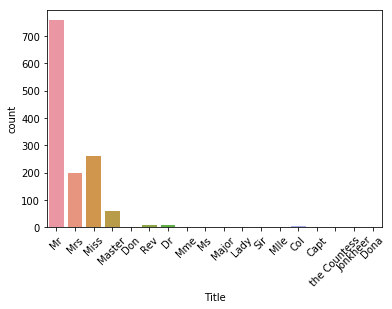

In [12]:
g=sns.countplot(x='Title',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

In [13]:
# We can replace many titles with a more common name or classify them as Rare.
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Capt', 'Col',\
                                             'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
dataset[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Sex

In [14]:
# Sex-Survived
# Sex=female > 74 % . Hence 'Sex' should be included in the Model.
train_df[['Sex','Survived']].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived',ascending=False)


,Sex,Survived
0,female,0.742038
1,male,0.188908


Ticket

In [15]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
dataset["Ticket"] = Ticket

In [16]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A5,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STONO2,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,X,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,X,Mr


Cabin

In [17]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])


In [18]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,X,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A5,Mr
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC,Mrs
2,26.0,X,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STONO2,Miss
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,X,Mrs
4,35.0,X,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,X,Mr


Embarked

In [19]:
# Embarked
freq_port=train_df.Embarked.dropna().mode()[0]
freq_port


'S'

In [20]:
dataset['Embarked']=dataset['Embarked'].fillna(freq_port)

In [21]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,X,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A5,Mr
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC,Mrs
2,26.0,X,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STONO2,Miss
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,X,Mrs
4,35.0,X,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,X,Mr


Feature Analysis (Numeric)¶
Variable-by-Variable Correlation Analysis of Non Missing Numeric Values with Target Variables [Pclass,SibSp, PArch and Fare] to be Analysed [Age] remaining. Before doing this we will generate a correlation matrix with All Numeric features which include recently converted ones too. this will give a summary .

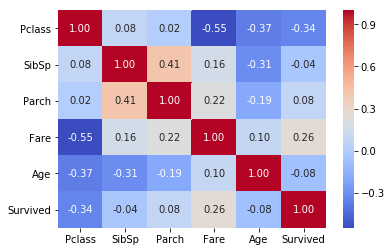

In [22]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
sns.heatmap(train_df[["Pclass","SibSp","Parch","Fare","Age","Survived"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")



Pclass

In [23]:
# Pclass(D)-Survived
# Significant correlation with Pclass=1 > 62 %. Should be included in our Model.
train_df[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


SibSp & Parch

In [24]:
# SibSp(D)-Survived
train_df[['SibSp','Survived']].groupby(['SibSp'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [25]:
# Parch(D)-Survived
train_df[['Parch','Survived']].groupby(['Parch'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [26]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)
  


In [27]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,Single,SmallF,MedF,LargeF
0,22.0,X,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A5,Mr,2,0,1,0,0
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC,Mrs,2,0,1,0,0
2,26.0,X,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STONO2,Miss,1,1,0,0,0
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,X,Mrs,2,0,1,0,0
4,35.0,X,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,X,Mr,1,1,0,0,0


Fare

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


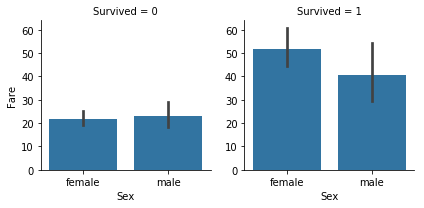

In [28]:
# Fare(C)-Survived
sns.FacetGrid(train_df,col='Survived').map(sns.barplot,'Sex','Fare')
# Higher Fare paying passengers survived , hence it can be included in the model.Since its continuous numeric , a
# new feature FareRange needs to be created for analysis

# Since Fare is Continuous we will plot distribution plot next

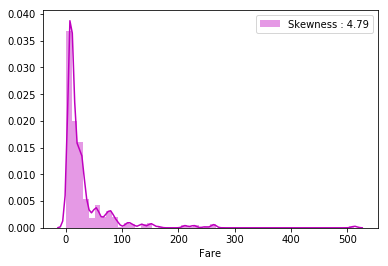

In [29]:
# Explore Fare distribution 
g = sns.distplot(train_df["Fare"], color="m", label="Skewness : %.2f"%(train_df["Fare"].skew()))
g = g.legend(loc="best")

# This highly skewed plot should be transformed using log t oreduce the skewness

In [30]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

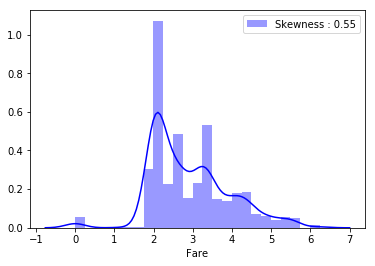

In [31]:
# Plot after reducing skewness
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [32]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,Single,SmallF,MedF,LargeF
0,22.0,X,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A5,Mr,2,0,1,0,0
1,38.0,C,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC,Mrs,2,0,1,0,0
2,26.0,X,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STONO2,Miss,1,1,0,0,0
3,35.0,C,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,X,Mrs,2,0,1,0,0
4,35.0,X,S,2.085672,"Allen, Mr. William Henry",0,5,3,male,0,0.0,X,Mr,1,1,0,0,0


In [33]:
dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].dropna().median())
#train_df['Fare']=train_df['Fare'].fillna(train_df['Fare'].dropna().median(),inplace=True)


In [34]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,Single,SmallF,MedF,LargeF
0,22.0,X,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A5,Mr,2,0,1,0,0
1,38.0,C,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC,Mrs,2,0,1,0,0
2,26.0,X,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STONO2,Miss,1,1,0,0,0
3,35.0,C,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,X,Mrs,2,0,1,0,0
4,35.0,X,S,2.085672,"Allen, Mr. William Henry",0,5,3,male,0,0.0,X,Mr,1,1,0,0,0


In [35]:
dataset['FareBand']=pd.qcut(dataset['Fare'],4)
dataset[['FareBand','Survived']].groupby(['FareBand'],as_index=False).mean()

,FareBand,Survived
0,"(-0.001, 2.066]",0.197309
1,"(2.066, 2.671]",0.303571
2,"(2.671, 3.443]",0.441048
3,"(3.443, 6.239]",0.600000


In [36]:
dataset.loc[dataset['Fare'] <=2.06,'Fare']=0
dataset.loc[(dataset['Fare'] <=2.67) & (dataset['Fare'] > 2.06)  ,'Fare']=1
dataset.loc[(dataset['Fare'] <=3.44) & (dataset['Fare'] > 2.67)  ,'Fare']=2
dataset.loc[(dataset['Fare'] <=6.2) & (dataset['Fare'] > 3.44)  ,'Fare']=3
dataset.loc[dataset['Fare'] > 6.2  ,'Fare']=4
dataset['Fare']=dataset['Fare'].astype(int)

In [37]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,Single,SmallF,MedF,LargeF,FareBand
0,22.0,X,S,0,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A5,Mr,2,0,1,0,0,"(-0.001, 2.066]"
1,38.0,C,C,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC,Mrs,2,0,1,0,0,"(3.443, 6.239]"
2,26.0,X,S,1,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STONO2,Miss,1,1,0,0,0,"(2.066, 2.671]"
3,35.0,C,S,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,X,Mrs,2,0,1,0,0,"(3.443, 6.239]"
4,35.0,X,S,1,"Allen, Mr. William Henry",0,5,3,male,0,0.0,X,Mr,1,1,0,0,0,"(2.066, 2.671]"


Age : Missing Value Treatment , Feature Engineering

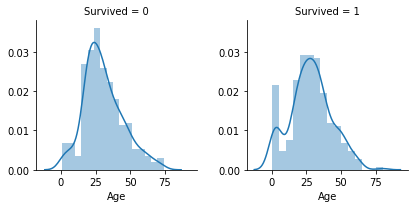

In [38]:
# Age
# Explore Age distibution
g = sns.FacetGrid(train_df,col='Survived')
g.map(sns.distplot,'Age')


In [39]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)
for i in index_NaN_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) &
                               (dataset['Parch'] == dataset.iloc[i]["Parch"]) &
                               (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        #print(i)
        dataset['Age'].iloc[i] = age_med
        #print(train_df.iloc[i])

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
dataset['AgeBand']=pd.cut(dataset['Age'],5)


In [41]:
dataset[['AgeBand','Survived']].groupby(['AgeBand'],as_index=False).mean()

,AgeBand,Survived
0,"(0.0902, 16.136]",0.500000
1,"(16.136, 32.102]",0.341719
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [42]:
dataset.loc[dataset['Age'] <=16 , 'Age' ] = 0
dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <=32) , 'Age' ] = 1
dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <=48) , 'Age' ] = 2
dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <=64) , 'Age' ] = 3
dataset.loc[(dataset['Age'] > 64) , 'Age' ] = 4
dataset['Age']=dataset['Age'].astype(int)


In [43]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,Single,SmallF,MedF,LargeF,FareBand,AgeBand
0,1,X,S,0,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A5,Mr,2,0,1,0,0,"(-0.001, 2.066]","(16.136, 32.102]"
1,2,C,C,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC,Mrs,2,0,1,0,0,"(3.443, 6.239]","(32.102, 48.068]"
2,1,X,S,1,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STONO2,Miss,1,1,0,0,0,"(2.066, 2.671]","(16.136, 32.102]"
3,2,C,S,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,X,Mrs,2,0,1,0,0,"(3.443, 6.239]","(32.102, 48.068]"
4,2,X,S,1,"Allen, Mr. William Henry",0,5,3,male,0,0.0,X,Mr,1,1,0,0,0,"(2.066, 2.671]","(32.102, 48.068]"


Data PreProcessing before Modelling

In [44]:
dataset.head(1)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,Single,SmallF,MedF,LargeF,FareBand,AgeBand
0,1,X,S,0,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A5,Mr,2,0,1,0,0,"(-0.001, 2.066]","(16.136, 32.102]"


In [45]:
# DROP
dataset=dataset.drop(['Name','Parch','PassengerId','SibSp','Fsize','FareBand','AgeBand'],axis=1)

In [46]:
dataset.head(1)

,Age,Cabin,Embarked,Fare,Pclass,Sex,Survived,Ticket,Title,Single,SmallF,MedF,LargeF
0,1,X,S,0,3,male,0.0,A5,Mr,0,1,0,0


In [47]:
# ENCODING
dataset=pd.get_dummies(dataset)


In [48]:
dataset.columns

Index(['Age', 'Fare', 'Pclass', 'Survived', 'Single', 'SmallF', 'MedF',
       'LargeF', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Sex_female', 'Sex_male', 'Ticket_A', 'Ticket_A4',
       'Ticket_A5', 'Ticket_AQ3', 'Ticket_AQ4', 'Ticket_AS', 'Ticket_C',
       'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC', 'Ticket_Fa',
       'Ticket_LINE', 'Ticket_LP', 'Ticket_PC', 'Ticket_PP', 'Ticket_PPP',
       'Ticket_SC', 'Ticket_SCA3', 'Ticket_SCA4', 'Ticket_SCAH', 'Ticket_SCOW',
       'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP',
       'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP',
       'Ticket_STONO', 'Ticket_STONO2', 'Ticket_STONOQ', 'Ticket_SWPP',
       'Ticket_WC', 'Ticket_WEP', 'Ticket_X', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare'],
      dtype='object')

In [49]:
dataset=pd.get_dummies(dataset,prefix=['Pclass','Age','Fare'],columns=['Pclass','Age','Fare'])

In [50]:
dataset.columns

Index(['Survived', 'Single', 'SmallF', 'MedF', 'LargeF', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Cabin_X', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Ticket_A', 'Ticket_A4', 'Ticket_A5', 'Ticket_AQ3',
       'Ticket_AQ4', 'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON',
       'Ticket_FC', 'Ticket_FCC', 'Ticket_Fa', 'Ticket_LINE', 'Ticket_LP',
       'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCA3',
       'Ticket_SCA4', 'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS',
       'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP',
       'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO',
       'Ticket_STONO2', 'Ticket_STONOQ', 'Ticket_SWPP', 'Ticket_WC',
       'Ticket_WEP', 'Ticket_X', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_0',
       'Age_1', 'Age_2', 'Age_3', 'Age_4', 

In [51]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [52]:
## Separate train features and label 
train["Survived"] = train["Survived"].astype(int)
X_train = train.drop(labels = ["Survived"],axis = 1)
Y_train = train["Survived"]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
X_test=test

In [54]:
print(X_train.shape)
print(X_test.shape)


(891, 73)
(418, 73)


**MODELLING**

Cross Validation

In [55]:
# Applying k-Fold Cross Validation

kfold= StratifiedKFold(n_splits=10)

Classifiers (Building Classifier Array)

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn

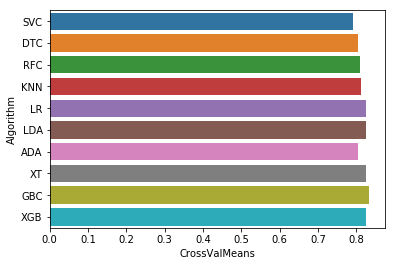

In [56]:
random_state=2
classifiers=[]
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))
cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(estimator=classifier,X=X_train,y=Y_train,cv=kfold,scoring='accuracy',n_jobs=-1))
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
# Cross Validation Results
cv_res=pd.DataFrame({'CrossValMeans':cv_means , 'CrossValErrors':cv_std , 'Algorithm':['SVC','DTC','RFC','KNN','LR','LDA','ADA','XT','GBC','XGB']})

sns.barplot('CrossValMeans','Algorithm',data=cv_res)


Hyper Parameter Tuning

In [57]:
# SVC
svc_classifier=SVC(probability=True)
svc_param_grid = [{'C': [1], 'kernel': ['rbf'],
                   'gamma': [0.1],
                  'cache_size':[100],
                  'coef0':[0.1],
                  'degree':[1],
                  'tol':[0.001]}]

gs_SVC = GridSearchCV(estimator = svc_classifier,
                           param_grid = svc_param_grid,
                           scoring = 'accuracy',
                           cv = kfold,
                           n_jobs = -1)
gs_SVC = gs_SVC.fit(X_train, Y_train)
svc_best_params = gs_SVC.best_params_
svc_best_score = gs_SVC.best_score_
svc_best=gs_SVC.best_estimator_
svc_best_score


0.83613916947250277

In [58]:
svc_best

SVC(C=1, cache_size=100, class_weight=None, coef0=0.1,
  decision_function_shape='ovr', degree=1, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
# DTC
dtc_classifier=DecisionTreeClassifier()
dtc_param_grid = [{'criterion': ['gini'], 
                   "min_samples_split": [2],
              "max_depth": [None],
              "min_samples_leaf": [5],
              "max_leaf_nodes": [10],
                   'splitter': ['best']}]
gs_DTC = GridSearchCV(estimator = dtc_classifier,
                           param_grid = dtc_param_grid,
                           scoring = 'accuracy',
                           cv = kfold,
                           n_jobs = -1)
gs_DTC = gs_DTC.fit(X_train, Y_train)
dtc_best_params = gs_DTC.best_params_
dtc_best_score = gs_DTC.best_score_
dtc_best=gs_DTC.best_estimator_
dtc_best_score

0.83277216610549942

In [60]:
dtc_best

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [61]:
# RFC
rfc_classifier=RandomForestClassifier()
rfc_param_grid = [{'n_estimators':[1200] ,'criterion': ['entropy'],
                   'max_features':['auto'] ,'min_samples_split':[9],'min_samples_leaf':[2],
                  'bootstrap' : [True], 'n_jobs':[-1] ,'oob_score':[True]}]
gs_RFC = GridSearchCV(estimator = rfc_classifier,
                           param_grid = rfc_param_grid,
                           scoring = 'accuracy',
                           cv = kfold,
                           n_jobs = -1)
gs_RFC = gs_RFC.fit(X_train, Y_train)
rfc_best_params = gs_RFC.best_params_
rfc_best_score = gs_RFC.best_score_
rfc_best=gs_RFC.best_estimator_
rfc_best_score

0.83277216610549942

In [62]:
rfc_best

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [63]:
# KNN
knn_classifier=KNeighborsClassifier()
knn_param_grid = [{'n_neighbors':[10],'weights':['uniform'],'algorithm':['brute'],
                  }]
gs_KNN = GridSearchCV(estimator = knn_classifier,
                           param_grid = knn_param_grid,
                           scoring = 'accuracy',
                           cv = kfold,
                           n_jobs = -1)
gs_KNN = gs_KNN.fit(X_train, Y_train)
knn_best_params = gs_KNN.best_params_
knn_best_score = gs_KNN.best_score_
knn_best=gs_KNN.best_estimator_
knn_best_score

0.82379349046015715

In [64]:
knn_best

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [65]:
# LR
lr_classifier=LogisticRegression()
lr_param_grid = [{'penalty':['l1','l2'] , 'C':[1]}]
gs_LR = GridSearchCV(estimator = lr_classifier,
                           param_grid = lr_param_grid,
                           scoring = 'accuracy',
                           cv = kfold,
                           n_jobs = -1)
gs_LR = gs_LR.fit(X_train, Y_train)
lr_best_params = gs_LR.best_params_
lr_best_score = gs_LR.best_score_
lr_best=gs_LR.best_estimator_
lr_best_score

0.8271604938271605

In [66]:
lr_best

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
# # LDA
# lda_classifier=DecisionTreeClassifier()
# lda_param_grid = [{'criterion': ['gini','entropy'], 'splitter': ['best','random']}]
# gs_LDA = GridSearchCV(estimator = lda_classifier,
#                            param_grid = lda_param_grid,
#                            scoring = 'accuracy',
#                            cv = kfold,
#                            n_jobs = -1)
# gs_LDA = gs_LDA.fit(X_train, Y_train)
# lda_best_params = gs_LDA.best_params_
# lda_best_score = gs_LDA.best_score_
# lda_best_score

In [68]:
# ADA - DTC
adadtc_classifier=AdaBoostClassifier(dtc_best)
adadtc_param_grid = [{'n_estimators':[500], 
                      "learning_rate":  [0.1],
                      "algorithm" : ["SAMME"],
                     }]
gs_ADADTC = GridSearchCV(estimator = adadtc_classifier,
                           param_grid = adadtc_param_grid,
                           scoring = 'accuracy',
                           cv = kfold,
                           n_jobs = -1)
gs_ADADTC = gs_ADADTC.fit(X_train, Y_train)
adadtc_best_params = gs_ADADTC.best_params_
adadtc_best_score = gs_ADADTC.best_score_
adadtc_best=gs_ADADTC.best_estimator_
adadtc_best_score

0.83726150392817056

In [69]:
adadtc_best

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=500, random_state=None)

In [70]:
# XT
xt_classifier=ExtraTreesClassifier()
xt_param_grid = [{'n_estimators':[100],
                 'criterion':['entropy'],
                 'max_features':[None],
                 'max_depth':[None],
                 'min_samples_split':[2],
                 'min_samples_leaf':[10]
                 }]
gs_XT = GridSearchCV(estimator = xt_classifier,
                           param_grid = xt_param_grid,
                           scoring = 'accuracy',
                           cv = kfold,
                           n_jobs = -1)
gs_XT = gs_XT.fit(X_train, Y_train)
xt_best_params = gs_XT.best_params_
xt_best_score = gs_XT.best_score_
xt_best=gs_XT.best_estimator_
xt_best_score

0.81481481481481477

In [71]:
xt_best

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [72]:
# # XGB
# xgb_classifier=XGBClassifier()
# xgb_param_grid = [{'booster':['gbtree', 'gblinear','dart'] ,
#                    'min_child_weight':[0.01,0.5,1,1.5] ,
#                   'max_depth' : [3,5,8,10] ,
#                   'gamma':[0,0.5,1,2] ,
#                   'subsample': [0.5,0.75,1] ,
#                   'colsample_bytree' : [0.5,0.75,1] ,
#                   'reg_lambda' : [0.5,1,1.5] ,
#                   'scale_pos_weight':[1,2,5]}]
# gs_XGB = GridSearchCV(estimator = xgb_classifier,
#                            param_grid = xgb_param_grid,
#                            scoring = 'accuracy',
#                            cv = kfold,
#                            n_jobs = -1)
# gs_XGB = gs_XGB.fit(X_train, Y_train)
# xgb_best_params = gs_XGB.best_params_
# xgb_best_score = gs_XGB.best_score_
# xgb_best=gs_XGB.best_estimator_
# xgb_best_score

In [73]:
#xgb_classifier.get_params().keys()

Plotting Learning Curves

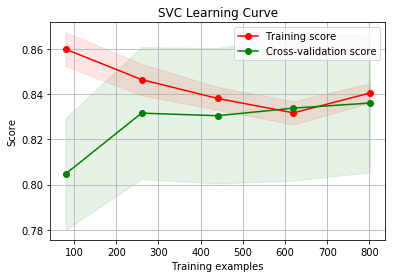

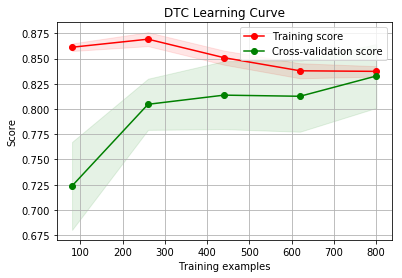

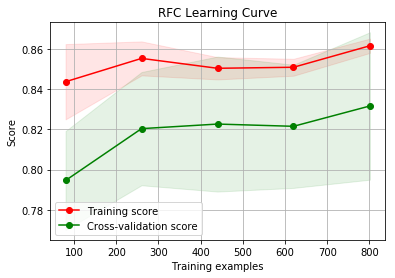

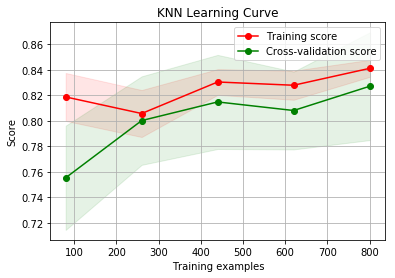

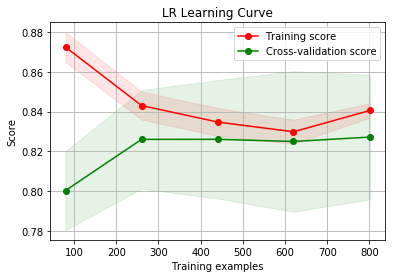

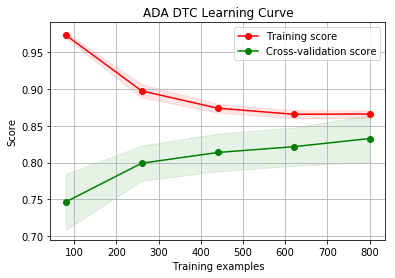

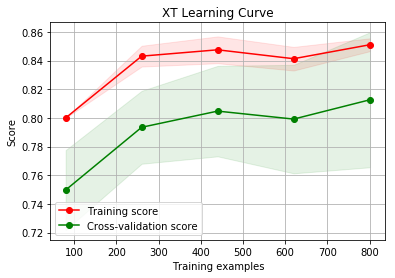

In [74]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g=plot_learning_curve(gs_SVC.best_estimator_,"SVC Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_DTC.best_estimator_,"DTC Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_RFC.best_estimator_,"RFC Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_KNN.best_estimator_,"KNN Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_LR.best_estimator_,"LR Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_ADADTC.best_estimator_,"ADA DTC Learning Curve",X_train,Y_train,cv=kfold)
g=plot_learning_curve(gs_XT.best_estimator_,"XT Learning Curve",X_train,Y_train,cv=kfold)

Ensemble Modelling

In [75]:
votingC = VotingClassifier(estimators=[('svc', svc_best), ('dtc', dtc_best),
('rfc', rfc_best), ('knn',knn_best),('lr',lr_best),('adadtc',adadtc_best),('xt',xt_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, Y_train)

In [76]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)